## Chapter 2 - Statistical Learning

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd

In [26]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score
from sklearn.mixture.gaussian_mixture import _compute_precision_cholesky
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier

In [39]:
BLUE, ORANGE, BLUE1 = '#57B5E8', '#E69E00', '#174A7E'
GRAY1, GRAY4, PURPLE = '#231F20', '#646369', '#A020F0'

# configure all plots font family and border line widths
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['axes.linewidth'] = 0.5

### Data

For the purpose of learning, I generate the data using the recipe described in another book: The Elements of Statistical Learning. This way I will be able to calculate Bayesian error (irreducible error) for the train data and draw more samples to calculate test error. 

In [10]:
# Generate 10 means from bivariate Gaussian distribution N((1,0),I) for class BLUE
blue_means = np.empty((0,2), dtype=np.float64)
mean = (1,0)
cov = [[1,0],[0,1]]
for i in range(10):
    x1, x2 = np.random.multivariate_normal(mean, cov, 3).T
    point = np.array([[x1.mean(), x2.mean()]])
    blue_means = np.append(blue_means, point, axis=0)
    
# Generate 10 means from bivariate Gaussian distribution N((1,0),I) for class ORANGE
orange_means = np.empty((0,2), dtype=np.float64)
mean = (0,1)
cov = [[1,0],[0,1]]
for i in range(10):
    x1, x2 = np.random.multivariate_normal(mean, cov, 3).T
    point = np.array([[x1.mean(), x2.mean()]])
    orange_means = np.append(orange_means, point, axis=0)
    
all_means = np.vstack((blue_means, orange_means))

In [11]:
gaussian_mixture_model = GaussianMixture(
    n_components=20,
    covariance_type='spherical',
    means_init=all_means,
    random_state=1
).fit(all_means)

gaussian_mixture_model.covariances_ = [1/5]*20

gaussian_mixture_model.precisions_cholesky_ = _compute_precision_cholesky(
    gaussian_mixture_model.covariances_,
    gaussian_mixture_model.covariance_type)

In [12]:
X_train, y_train = gaussian_mixture_model.sample(200)
y_train = np.where(y_train >= 10, 1, 0)

### Plotting functions

In [17]:
def generate_data_points_plot(X, y, title):
    """Plot the features in X."""
    fix, ax = plt.subplots(figsize=(6,6))
    ax.scatter(X[:,0], X[:,1], facecolors='none', linewidths=1.7, edgecolors=np.array([[BLUE, ORANGE][i] for i in y]))
    ax.title.set_text(title)
    ax.set_xlabel('X1')
    ax.set_ylabel('X2')
    return fix, ax

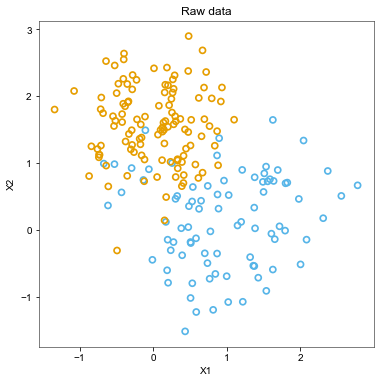

In [18]:
# test
_, _ = generate_data_points_plot(X_train, y_train, 'Raw data')

In [36]:
def fill_meshgrid(X_train, n, predict):
    """Plot the class regions."""
    x1, x2 = (np.linspace(X_train[:,c].min()-.25, X_train[:,c].max()+.25, n) for c in range(X_train.shape[1]))
    grid = np.array(np.meshgrid(x1, x2)).T.reshape(-1, 2) 
    y_hat = predict(grid)
    return grid, y_hat

In [37]:
def generate_decision_boundary(X_train, n, predict):
    """Prepare the data for decision boundary plot."""
    X, y = fill_meshgrid(X_train, n, predict)
    return X[:, 0].reshape(n, n), X[:, 1].reshape(n, n), y.reshape(n, n)

### Bayes classifier

In [62]:
def bayes_predict(X_test):
    components_proba = gaussian_mixture_model.predict_proba(X_test)
    blue_proba = np.sum(components_proba[:, :10], axis=1)
    orange_proba = np.sum(components_proba[:, 10:], axis=1)
    y_hat = np.where(blue_proba < orange_proba, 1, 0)
    return y_hat

In [172]:
X_bayes, y_bayes = gaussian_mixture_model.sample(10000)
y_bayes = np.where(y_bayes >= 10, 1, 0)

In [173]:
bayes_error_rate = 1 - accuracy_score(y_true=y_bayes, y_pred=bayes_predict(X_bayes))

In [174]:
print(f"Bayes error rate: {bayes_error_rate:.3f}")

Bayes error rate: 0.081


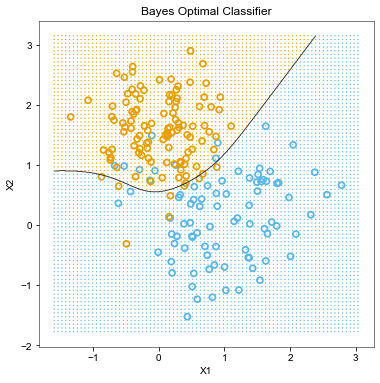

In [81]:
X_grid, y_grid = fill_meshgrid(X_train, 80, bayes_predict)
X0, X1, Y = generate_decision_boundary(X_train, 700, bayes_predict)
fig, ax = generate_data_points_plot(X_train, y_train, 'Bayes Optimal Classifier')
ax.scatter(X_grid[:, 0], X_grid[:, 1], marker='.', lw=0.5, s=2, c= np.array([[BLUE, ORANGE][i] for i in y_grid]))
ax.contour(X0, X1, Y, [0.5], colors=GRAY1, linewidths=[0.8])

### Linear regression

Technically described in the next chapter, but in the Elements of Statistical Learning authors compared the two ... daÄ‡ dalej opis

In [23]:
def least_squares(X_train, y_train):
    """Returns coeffs estimators using least squares method"""
    constant_column = np.ones((X_train.shape[0],1), dtype=np.int64)
    X_train = np.append(constant_column, X_train, axis=1)
    y_hat = np.dot(np.linalg.inv(np.dot(X_train.T, X_train)),np.dot(X_train.T, y_train))
    return y_hat

In [155]:
def get_error(X, y_true, fun):
    """Return error rate by comparing vector of true values @y_true
    with prediction of model @m on data @X."""
    y_hat = fun(X)
#     error_rate = np.mean(np.where(y_hat == y_true, 0, 1))
    error_rate = 1 - np.mean(1*np.equal(y_hat, y_true))
    return error_rate

In [156]:
m_lm = least_squares(X_train, y_train)
print(m_lm)

[ 0.36557088 -0.22297848  0.31383948]


In [157]:
#Comparsion with linear model from sklearn (for sanity check)
m_lm = LinearRegression(fit_intercept=True).fit(X_train, y_train)
print('intercept:',m_lm.intercept_,'\ncoefs:',str(m_lm.coef_))

intercept: 0.3655708836333973 
coefs: [-0.22297848  0.31383948]


In [158]:
def predict_linear_model(X_test):
    y_hat = m_lm.predict(X_test)
    return np.where(y_hat > .5, 1, 0)

In [159]:
mlm_error = get_error(X_train, y_train, predict_linear_model)

Text(-1.4408069113609427, -1.45, 'Training Error: 0.100')

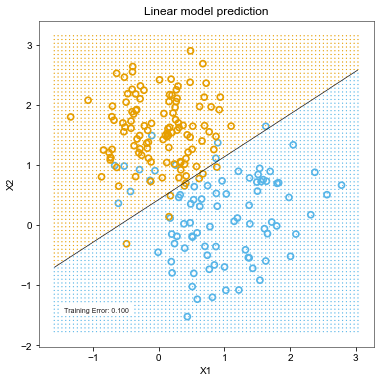

In [92]:
X_grid, y_grid = fill_meshgrid(X_train, 80, predict_linear_model)
X0, X1, Y = generate_decision_boundary(X_train, 800, predict_linear_model)
fig, ax = generate_data_points_plot(X_train, y_train, 'Linear model prediction')
ax.scatter(X_grid[:, 0], X_grid[:, 1], marker='.', lw=0.5, s=2, c= np.array([[BLUE, ORANGE][i] for i in y_grid]))
ax.contour(X0, X1, Y, [0.5], colors=GRAY1, linewidths=[0.7])
parms = {'color': GRAY1, 'fontsize': 10,
             'bbox': {'facecolor': 'white', 'pad': 3, 'edgecolor': 'none'}}
ax.text(X_grid[:, 0].min()+.15, -1.45, f'Training Error: {mlm_error:.3f}', **parms)

### K-Nearest Neighbor Classifier

In [93]:
neigh = KNeighborsClassifier(n_neighbors=1).fit(X_train, y_train)

In [96]:
knn1 = get_error(X_train, y_train, neigh.predict)

Text(-1.4408069113609427, -1.45, 'Training Error: 0.000')

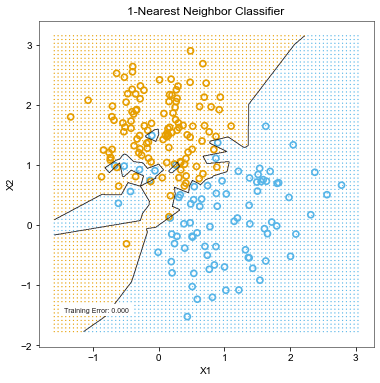

In [98]:
X_grid, y_grid = fill_meshgrid(X_train, 80, neigh.predict)
X0, X1, Y = generate_decision_boundary(X_train, 700, neigh.predict)
fig, ax = generate_data_points_plot(X_train, y_train, '1-Nearest Neighbor Classifier')
ax.scatter(X_grid[:, 0], X_grid[:, 1], marker='.', lw=0.5, s=2, c= np.array([[BLUE, ORANGE][i] for i in y_grid]))
ax.contour(X0, X1, Y, [0.5], colors=GRAY1, linewidths=[0.8])
parms = {'color': GRAY1, 'fontsize': 10,
             'bbox': {'facecolor': 'white', 'pad': 3, 'edgecolor': 'none'}}
ax.text(X_grid[:, 0].min()+.15, -1.45, f'Training Error: {knn1:.3f}', **parms)

In [101]:
neigh = KNeighborsClassifier(n_neighbors=10).fit(X_train, y_train)

In [102]:
knn10 = get_error(X_train, y_train, neigh.predict)

Text(-1.4408069113609427, -1.45, 'Training Error: 0.070')

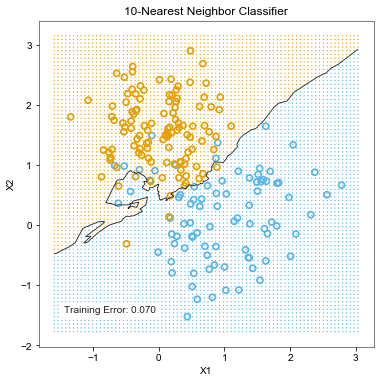

In [105]:
X_grid, y_grid = fill_meshgrid(X_train, 80, neigh.predict)
X0, X1, Y = generate_decision_boundary(X_train, 700, neigh.predict)
fig, ax = generate_data_points_plot(X_train, y_train, '10-Nearest Neighbor Classifier')
ax.scatter(X_grid[:, 0], X_grid[:, 1], marker='.', lw=0.5, s=2, c= np.array([[BLUE, ORANGE][i] for i in y_grid]))
ax.contour(X0, X1, Y, [0.5], colors=GRAY1, linewidths=[0.8])
parms = {'color': GRAY1, 'fontsize': 10,
             'bbox': {'facecolor': 'white', 'pad': 3, 'edgecolor': 'none'}}
ax.text(X_grid[:, 0].min()+.15, -1.45, f'Training Error: {knn10:.3f}', **parms)

In [106]:
neigh = KNeighborsClassifier(n_neighbors=30).fit(X_train, y_train)

In [107]:
knn30 = get_error(X_train, y_train, neigh.predict)

Text(-1.4408069113609427, -1.45, 'Training Error: 0.080')

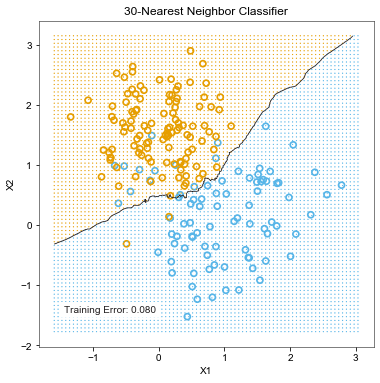

In [108]:
X_grid, y_grid = fill_meshgrid(X_train, 80, neigh.predict)
X0, X1, Y = generate_decision_boundary(X_train, 700, neigh.predict)
fig, ax = generate_data_points_plot(X_train, y_train, '30-Nearest Neighbor Classifier')
ax.scatter(X_grid[:, 0], X_grid[:, 1], marker='.', lw=0.5, s=2, c= np.array([[BLUE, ORANGE][i] for i in y_grid]))
ax.contour(X0, X1, Y, [0.5], colors=GRAY1, linewidths=[0.8])
parms = {'color': GRAY1, 'fontsize': 10,
             'bbox': {'facecolor': 'white', 'pad': 3, 'edgecolor': 'none'}}
ax.text(X_grid[:, 0].min()+.15, -1.45, f'Training Error: {knn30:.3f}', **parms)

### Training/Test error rate for different K values

In [175]:
X_test, y_test = gaussian_mixture_model.sample(10000)
y_test = np.where(y_test >= 10, 1, 0)

In [176]:
knn_performance = np.empty((0,3), dtype=np.float64)
for k in range(1,31):
    neighi = KNeighborsClassifier(n_neighbors=k).fit(X_train, y_train)
    train_error_rate = get_error(X_train, y_train, neighi.predict)
    test_error_rate = get_error(X_test, y_test, neighi.predict)
    knn_performance = np.append(knn_performance, np.array([[1/k, train_error_rate, test_error_rate]]), axis=0)

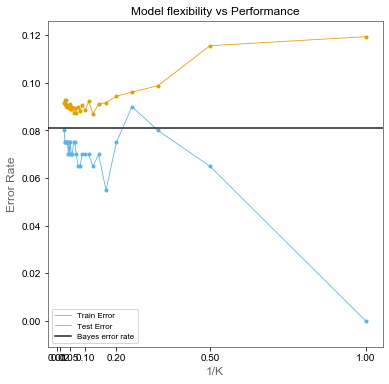

In [192]:
xt = [0.01, 0.02, 0.05, .1, .2, .5, 1.0]
# xti = list(range(len(xt)))

fix, ax = plt.subplots(figsize=(6,6))
ax.scatter(knn_performance[:,0], knn_performance[:,1], c=BLUE, s=9)
ax.plot(knn_performance[:,0], knn_performance[:,1], c=BLUE, linewidth=0.8, label='Train Error')
ax.scatter(knn_performance[:,0], knn_performance[:,2], c=ORANGE, s=9)
ax.plot(knn_performance[:,0], knn_performance[:,2], c=ORANGE, linewidth=0.8, label='Test Error')
ax.axhline(y = bayes_error_rate, color=GRAY1, label='Bayes error rate')
ax.set_xlabel('1/K', color=GRAY4, fontsize=12)
ax.set_ylabel('Error Rate', color=GRAY4, fontsize=12)
ax.legend(loc='lower left', prop={'size': 8})
ax.title.set_text('Model flexibility vs Performance')
ax.set_xticks(xt)